# House Prices Estimator

__Note:__ It's a competition from __Kaggle.com__ and the input data was retrieved from there.


## Data Analysis

In [1]:
import numpy as np
import pandas as pd

#load the files
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
data = pd.concat([train, test])

#size of training dataset
train_samples = train.shape[0]
test_samples = test.shape[0]

In [2]:
# remove the Id feature
data.drop(['Id'],1, inplace=True);

In [3]:
#data.describe()

In [4]:
datanum = data.select_dtypes([np.number])
datanum = datanum.fillna(datanum.dropna().mean())

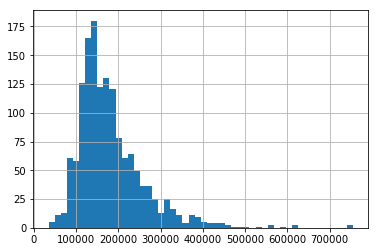

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
# Transforming to non-skewed SalePrice
#data.SalePrice = data.SalePrice.apply(np.log)
data.SalePrice.hist(bins=50)

In [6]:
# Correlation features
datanum.corr()['SalePrice'].drop('SalePrice').sort_values(ascending=False).head(10)

OverallQual     0.547865
GrLivArea       0.518693
GarageCars      0.444010
GarageArea      0.437270
TotalBsmtSF     0.431030
1stFlrSF        0.421430
FullBath        0.394865
TotRmsAbvGrd    0.388821
YearBuilt       0.368417
YearRemodAdd    0.352833
Name: SalePrice, dtype: float64

In [7]:
def getDataWithHighCorrFeatures(data, numberFeatures=10):
    high_corr_feat_names = data.corr()['SalePrice'].drop('SalePrice').sort_values(ascending=False).head(numberFeatures).axes[0].tolist()
    #high_corr_feat_names.remove('SalePrice')
    return data[high_corr_feat_names]

### KFold

In [8]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, random_state=13)#, shuffle=True)
print(kf)

KFold(n_splits=10, random_state=13, shuffle=False)


In [9]:
#plotting PCA
from sklearn.decomposition import PCA

def getX_PCA(X):
    pca = PCA(n_components=1)
    return pca.fit(X).transform(X)
    
def plotPCA(X, y):
    pca = PCA(n_components=1)
    X_r = pca.fit(X).transform(X)
    plt.plot(X_r, y, 'x')

In [11]:
from sklearn.covariance import EllipticEnvelope

def removeAnomalies(X_train, y_train, verbose=False):
    # fit the model
    ee = EllipticEnvelope(contamination=0.01,
                          assume_centered=True,
                          random_state=13)
    ee.fit(X_train)
    pred = ee.predict(X_train)

    X_anom = X_train[pred != 1]
    y_anom = y_train[pred != 1]
    X_no_anom = X_train[pred == 1]
    y_no_anom = y_train[pred == 1]
    
    if (verbose):
        print("Number samples no anomalies: {}".format(X_no_anom.shape[0]))

    #after removing anomalies
    #plt.scatter(getX_PCA(X_no_anom), y_no_anom)
    #plt.scatter(getX_PCA(X_anom), y_anom)
    
    return X_no_anom, y_no_anom

def idxNotAnomalies(X):
    ee = EllipticEnvelope(contamination=0.01,
                          assume_centered=True,
                          random_state=13)
    ee.fit(X)
    pred = ee.predict(X)

    return [index[0] for index, x in np.ndenumerate(pred) if x == 1]

### Model

In [90]:
# Linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error

def train(X_train, y_train, verbose=False):
    lr = LinearRegression()

    #
    batch = 0
    for train_idx, val_idx in kf.split(X_train, y_train):
        X_t, X_v = X_train[train_idx], X_train[val_idx]
        y_t, y_v = y_train[train_idx], y_train[val_idx]

        #training
        lr.fit(X_t, y_t)

        #calculate costs
        t_error = mean_squared_log_error(y_t, lr.predict(X_t))**0.5
        v_error = mean_squared_log_error(y_v, lr.predict(X_v))**0.5
        if verbose:
            print("{}) Training error: {:.2f}  Validation error: {:.2f} Score: {:.2f}"
                  .format(batch, t_error, v_error, lr.score(X_v, y_v)))
        batch += 1
        
    return lr

def metrics(model, X, y, verbose=False):
    #Scores
    if verbose:
        print("Training score: {:.4f}".format(model.score(X, y)))
    #RMSLE
    #print(np.count_nonzero(~np.isfinite(model.predict(X))))
    rmsle = mean_squared_log_error(y, model.predict(X))**0.5
    if verbose:
        print("RMSLE: {:.4f}".format(rmsle))
        # Plotting the results
        plt.scatter(model.predict(X), y)
        
    return rmsle, model.score(X, y)

In [16]:
# Get polynomial features
from sklearn.preprocessing import PolynomialFeatures

def getPolynomial(X_train, X_no_anom, X_test):
    poly = PolynomialFeatures(degree=2)
    return poly.fit_transform(X_train), poly.fit_transform(X_no_anom), poly.fit_transform(X_test)

In [17]:
def getKeyWithMinError(X_train, X_no_amon, y_train, y_no_anom, verbose=False):
    rmsles = {}
    for f in range(1,X_train.shape[1]):
        model = train(X_no_anom[:,:f], y_no_anom, verbose=False)
        rmsles[f] = metrics(model, X_train[:,:f], y_train, verbose=False)

    min_error_key = min(rmsles, key=rmsles.get)
    
    if (verbose):
        print("Min error (k={}):{}".format(min_error_key, rmsles[min_error_key]))
    #model = train(X_train_pol[:,:min_error_key], y_train)
    #metrics(model, X_train_orig_pol[:,:min_error_key], y_train_orig)
    #pd.Series(rmsles).plot()
    return min_error_key


## Running Models

0
0
0
f:1 err:0.408 score:-0.000
0
0
0
0
0
0
f:2 err:0.207 score:0.734
0
0
0
0
0
0
0
0
0
0
f:3 err:0.192 score:0.785
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
f:4 err:0.188 score:0.800
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
f:5 err:0.178 score:0.775
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
f:6 err:0.179 score:0.744
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
f:7 err:0.178 score:0.765
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
f:8 err:0.175 score:0.813
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
f:9 err:0.169 score:0.800
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
f:10 err:0.160 score:0.859
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
f:11 err:0.1

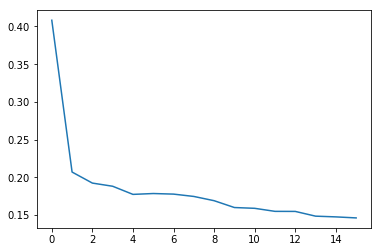

In [94]:
import warnings
warnings.filterwarnings('ignore')

errors = []
for f in range(1,17):
    #print("====Corr feat: {}====".format(f))
    datanum_high_corr = getDataWithHighCorrFeatures(datanum, f)

    y = np.array(data['SalePrice'])
    X = np.array(datanum_high_corr)

    #split by idx
    idx = train_samples
    X_train, X_test = X[:idx], X[idx:]
    y_train, y_test = y[:idx], y[idx:]
    
    #print("Shape X train: {}".format(X_train.shape))

    X_no_anom, y_no_anom = removeAnomalies(X_train, y_train)
    #print("Shape X train (no anom): {}".format(X_no_anom.shape))

    X_train, X_no_anom, X_test = getPolynomial(X_train, X_no_anom, X_test)
    #print("Shape X train (poly): {}".format(X_no_anom.shape))

    key = getKeyWithMinError(X_train, X_no_anom, y_train, y_no_anom)
    model = train(X_no_anom[:,:key], y_no_anom)
    error, score = metrics(model, X_train[:,:key], y_train)
    
    print("f:{} err:{:.3f} score:{:.3f}".format(f, error, score))
    errors.append(error)

# show graph
pd.Series(errors).plot()

## Adding Categorical

In [95]:
features = data.select_dtypes([np.object]).axes[1].tolist()
features.append('SalePrice')

datacat = pd.get_dummies(data[features])
datacat = datacat.fillna(datacat.dropna().mean())
datacat.corr()['SalePrice'].drop('SalePrice').sort_values(ascending=False).head(10)

BsmtQual_Ex             0.379926
KitchenQual_Ex          0.352403
Foundation_PConc        0.351628
ExterQual_Gd            0.319726
ExterQual_Ex            0.314687
HeatingQC_Ex            0.307367
BsmtFinType1_GLQ        0.305922
GarageFinish_Fin        0.294661
Neighborhood_NridgHt    0.274490
SaleType_New            0.255194
Name: SalePrice, dtype: float64

In [96]:
features_order_by_corr = datacat.corr()['SalePrice'].drop('SalePrice').sort_values(ascending=False).axes[0].tolist()

In [97]:
import warnings
warnings.filterwarnings('ignore')

datanum_high_corr = getDataWithHighCorrFeatures(datanum, 15)
Xn = np.array(datanum_high_corr)
#choosing the number of categorical
num_cat = 10
Xc = np.array(datacat[features_order_by_corr[:num_cat]])
y = np.array(data['SalePrice'])

poly = PolynomialFeatures(degree=2)
Xpn = poly.fit_transform(Xn)

X = np.concatenate([Xpn, Xc], axis=1)
no_anom_idx = idxNotAnomalies(Xn[:idx]) #only from numeric features
print(Xpn.shape)
print(Xc.shape)
print(X.shape)

(2919, 136)
(2919, 10)
(2919, 146)


In [98]:
#split by idx
idx = train_samples
X_train, X_test = X[:idx], X[idx:]
y_train, y_test = y[:idx], y[idx:]

print("Shape X train: {}".format(X_train.shape))
print("Shape X test: {}".format(X_test.shape))

print("Shape X train (no anom): {}".format(X_train[no_anom_idx].shape))

Shape X train: (1460, 146)
Shape X test: (1459, 146)
Shape X train (no anom): (1445, 146)


In [99]:
X_no_anom = X_train[no_anom_idx]
y_no_anom = y_train[no_anom_idx]

errors = {}
scores = {}
for f in range(15^2,X_train.shape[1]):
    modelt = train(X_no_anom[:,:f], y_no_anom, verbose=False)
    err, score = metrics(modelt, X_train[:,:f], y_train, verbose=False)
    if err > 1e-7:
        errors[f] = err
        scores[f] = score
    else:
        break

min_error_key = min(errors, key=errors.get)
print("Min err:{:.3f}".format(errors[min_error_key]))

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
Min err:0.147


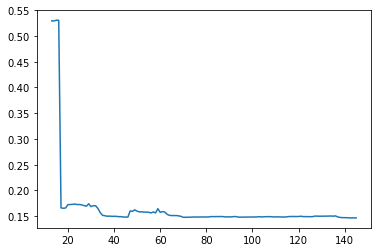

In [100]:
pd.Series(errors).plot()

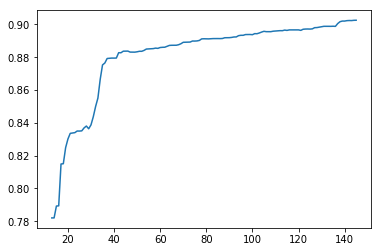

In [101]:
pd.Series(scores).plot()

In [102]:
print(min_error_key)

145


## Get Predictions

In [103]:
import os
from sklearn.model_selection import cross_val_score
#min_error_key = 350

modelt = train(X_no_anom[:,:min_error_key], y_no_anom, verbose=False)
err, score = metrics(modelt, X_train[:,:min_error_key], y_train, verbose=False)
print("Err: {:.3f} | R2: {:.3f}".format(err, score))


scores = cross_val_score(modelt, X_no_anom[:,:min_error_key], y_no_anom, 
                         scoring='neg_mean_squared_log_error', cv=10)
print(scores)
print(scores.mean())

0
Err: 0.147 | R2: 0.903


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [47]:
predict = modelt.predict(X_test[:,:min_error_key])

#predictions are logs, return to the value
predict = np.exp(predict)

file = "Id,SalePrice" + os.linesep

startId = 1461
for i in range(len(X_test)):
    file += "{},{}".format(startId, (int)(predict[i])) + os.linesep
    startId += 1

In [41]:
# Save to file
with open('attempt.txt', 'w') as f:
    f.write(file)

In [ ]:
# Using XGRegressor?
#lr = XGBRegressor(max_depth=5, n_estimators=250,min_child_weight=10)

